<a href="https://colab.research.google.com/github/soma2000-lang/Exploring-Detectron2/blob/main/CustomAugmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!python -m  pip install --q \
'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
!wget -q https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/datasets/braintumors_coco.zip
!unzip -q braintumors_coco.zip
     


In [7]:

import torch
from detectron2.utils.logger import setup_logger
logger = setup_logger()
from detectron2.data.datasets import register_coco_instances

In [8]:
# Some configurations
name_ds = "braintumors_coco"
name_ds_train = name_ds + "_train"
name_ds_test = name_ds + "_test"
image_root_train = name_ds + "/train"
image_root_test = name_ds + "/test"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af
json_file_test = name_ds + "/test/" + af
     

In [9]:

# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )
## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )


In [10]:

import os
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle


In [11]:

output_dir = "output/object_detector_augs"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")
nc = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
# Select a model
config_file_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
     

In [12]:
# Create a configuration file
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Download weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Set datasets
cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST = (name_ds_test,)
# Workers
cfg.DATALOADER.NUM_WORKERS = 4
# Solver
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.STEPS = (5000, 7000)
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.NESTROV = False
cfg.SOLVER.MAX_ITER = 10000
# checkpoint
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
# anchors
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[68.33245953, 112.91302277,  89.55701886, 144.71037342,  47.77637482]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.99819939, 0.78726896, 1.23598428]]
# pixels
cfg.MODEL.PIXEL_MEAN = [20.1962, 20.1962, 20.1962]
cfg.MODEL.PIXEL_STD = [39.5985, 39.5985, 39.5985]

# Evaluation
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD
# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir
     

In [13]:

# save configuration file for future use
with open(output_cfg_path, "wb") as f:
  pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)
     

In [14]:
from detectron2.data import DatasetMapper
import copy
import detectron2.data.transforms as T
import detectron2.data.detection_utils as utils
from detectron2.structures import BoxMode

class ExtendedAugInput(T.AugInput):
  def __init__(self, image, *, 
               boxes        = None, 
               sem_seg      = None, 
               dataset_dict = None):
    super().__init__(image, sem_seg=sem_seg, boxes=boxes)
    self.dataset_dict = dataset_dict
    self.is_train = True

class ExtendedDatasetMapper(DatasetMapper):
  def _convert_annotations(self, 
                           dataset_dict, 
                           boxes, 
                           image_shape):
    annos = []
    # get annotations info from dataset_dict
    for i, annotation in enumerate(
        dataset_dict.pop("annotations")):
      bbox = boxes[i]
      annotation["bbox"] = bbox
      annotation["bbox_mode"] = BoxMode.XYXY_ABS
      annos.append(annotation)

    instances = utils.annotations_to_instances(
        annos, image_shape, 
        mask_format=self.instance_mask_format
    )
    if self.recompute_boxes:
        instances.gt_boxes = instances.gt_masks.get_bounding_boxes()

    dataset_dict["instances"] = utils.filter_empty_instances(instances)

  def __call__(self, dataset_dict):
    # Step 1: Read images and annotations from dataset_dict
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], 
                            format=self.image_format)
    utils.check_image_size(dataset_dict, image)
    if "sem_seg_file_name" in dataset_dict:
        sem_seg_gt = utils.read_image(
            dataset_dict.pop("sem_seg_file_name"), "L"
            ).squeeze(2)
    else:
        sem_seg_gt = None

    boxes = np.array([
        BoxMode.convert(
            obj["bbox"], 
            obj["bbox_mode"], BoxMode.XYXY_ABS) 
        for obj in dataset_dict['annotations']])

    # Step 2: Perform transformations/augmentations
    aug_input = ExtendedAugInput(image, 
                       sem_seg      = sem_seg_gt, 
                       dataset_dict = dataset_dict,
                       boxes = boxes) 

    transforms    = self.augmentations(aug_input)
    image         = aug_input.image
    sem_seg_gt    = aug_input.sem_seg
    dataset_dict  = aug_input.dataset_dict
    boxes         = aug_input.boxes

    image_shape = image.shape[:2]  
    dataset_dict["image"] = torch.as_tensor(
        np.ascontiguousarray(image.transpose(2, 0, 1)))

    # Step 3: Convert annotations to instances
    if "annotations" in dataset_dict:
      self._convert_annotations(dataset_dict, 
                                boxes, 
                                image_shape)

    return dataset_dict

In [15]:

from detectron2.data import DatasetCatalog

class DataDictSampler():
  def __init__(self, name_ds):
    ds = DatasetCatalog.get(name_ds_train)
    self.ds = ds

  def get_items(self, n=3):
    indices = np.random.randint(
        low   = 0, 
        high  = len(self.ds)-1,
        size  = n)
    return [copy.deepcopy(self.ds[_]) for _ in indices]


In [16]:
class MixUpAug(T.Augmentation):
  def __init__(self, cfg, src_weight = 0.5, dst_weight = 0.5):
    self.cfg = cfg
    self.sampler = DataDictSampler(cfg.DATASETS.TRAIN[0])
    self.src_weight = src_weight
    self.dst_weight = dst_weight

  def get_transform(self, image, dataset_dict):
    cfg = self.cfg
    # Step 1: get one more random input
    ds_dict = self.sampler.get_items(n=1)[0]
    mu_image = utils.read_image(ds_dict["file_name"], 
                                format=cfg.INPUT.FORMAT)
    utils.check_image_size(ds_dict, mu_image)
    # Step 2: append annotations and get mix-up boxes
    annotations = ds_dict["annotations"]
    dataset_dict["annotations"] += annotations
    mu_boxes = np.array([
        BoxMode.convert(
            obj["bbox"], obj["bbox_mode"], 
            BoxMode.XYXY_ABS) 
        for obj in annotations
        ])

    # Step 3: return an object of MixUpTransform
    return MixUpTransform(image       = image,
                          mu_image    = mu_image,
                          mu_boxes    = mu_boxes,
                          src_weight  = self.src_weight,
                          dst_weight  = self.dst_weight)


  def __repr__(self):
    return f"MixUp(src {self.src_weight}, dst {self.dst_weight})"

class MixUpTransform(T.Transform):
  def __init__(self, image, mu_image, mu_boxes, 
               src_weight = 0.5, 
               dst_weight = 0.5):
    # Step 1: resize the mu_image and mu_boxes
    image_size = image.shape[:2]
    rse = T.ResizeShortestEdge([min(image_size)], 
                              min(image_size), 
                              "choice")
    aug_i = T.AugInput(image=mu_image, boxes = mu_boxes)
    rse(aug_i)
    mu_image, mu_boxes = aug_i.image, aug_i.boxes

    # Step 2: pad mu_image
    img = np.zeros_like(image).astype('float32')
    img[:mu_image.shape[0], :mu_image.shape[1], :]=mu_image

    # Step 3: save values
    self.mu_image 	  = img
    self.mu_boxes 	  = mu_boxes
    self.src_weight 	= src_weight
    self.dst_weight 	= dst_weight


  
  def apply_image(self, image):
    bl_tfm = T.BlendTransform(src_image   = self.mu_image, 
                              src_weight  = self.src_weight,
                              dst_weight  = self.dst_weight)
    return bl_tfm.apply_image(image)
    
  def apply_coords(self, coords):
    return coords

  def apply_box(self, boxes):
    # combine boxes
    boxes = np.vstack([boxes, self.mu_boxes])
    return boxes
     

In [17]:
class MosaicAug(T.Augmentation):
  def __init__(self, cfg):
    self.cfg = cfg
    self.sampler = DataDictSampler(cfg.DATASETS.TRAIN[0])

  def get_transform(self, image, dataset_dict):
    cfg = self.cfg
    # get three more random images
    mo_items = self.sampler.get_items()
    # images
    mo_images = []
    mo_boxes = []
    # create ShortestEdge resize to resize images
    for ds_dict in mo_items:
      mo_image = utils.read_image(ds_dict["file_name"], 
                                  format=cfg.INPUT.FORMAT)
      utils.check_image_size(ds_dict, mo_image)
      mo_images.append(mo_image)
      annotations = ds_dict["annotations"]
      # mo_boxes
      mo_boxes.append(np.array([
          BoxMode.convert(
              obj["bbox"], 
              obj["bbox_mode"], 
              BoxMode.XYXY_ABS) 
          for obj in annotations]))
      # add annotations
      dataset_dict["annotations"] += annotations

    mt = MosaicTransform(mo_images, mo_boxes)
    return mt

  def __repr__(self):
    return "MosaicAug(4)"

In [18]:

import numpy as np
import time

class MosaicTransform(T.Transform):
  def __init__(self, mo_images, mo_boxes):
    self.mo_images = mo_images
    self.mo_boxes = mo_boxes
    
  def get_loc_info(self, image):
    images = [image] + self.mo_images
    heights = [i.shape[0] for i in images]
    widths = [i.shape[1] for i in images]
    ch = max(heights[0], heights[1])
    cw = max(widths[0], widths[2])
    h = (max(heights[0], heights[1]) + 
         max(heights[2], heights[3]))
    w = (max(widths[0], widths[2]) + 
         max(widths[1], widths[3]))
    # pad or start coordinates
    y0, x0 = ch-heights[0], cw - widths[0]
    y1, x1 = ch-heights[1], cw
    y2, x2 = ch, cw - widths[2]
    y3, x3 = ch, cw
    x_pads = [x0, x1, x2, x3]
    y_pads = [y0, y1, y2, y3]
    return (h, w, ch, cw, widths, heights, x_pads, y_pads)
  
  def apply_image(self, image):
    # get the loc info
    self.loc_info = self.get_loc_info(image)
    h, w, ch, cw, widths, heights, x_pads, y_pads = self.loc_info
    # output
    output = np.zeros((h, w, 3)).astype('float32')
    images = [image] + self.mo_images
    for i, img in enumerate(images):
      output[y_pads[i]: y_pads[i] + heights[i],
             x_pads[i]: x_pads[i] + widths[i],
             :] = img

    return output

  def apply_coords(self, coords):
    return coords

  def apply_box(self, boxes):
    # combine boxes
    boxes = [boxes] + self.mo_boxes
    # now update location values
    _, _, _, _, _, _, x_pads, y_pads = self.loc_info
    for i, bbox in enumerate(boxes):
      bbox += np.array([x_pads[i], y_pads[i], x_pads[i], y_pads[i]])
    # flatten it
    boxes = np.vstack(boxes)
    return boxes


In [19]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

from detectron2.data import DatasetMapper
from detectron2.data import build_detection_train_loader

class BrainTumorTrainer(DefaultTrainer):
  """
  This trainer evaluate data on the `cfg.DATASETS.TEST` validation dataset every `cfg.TEST.EVAL_PERIOD` iterations.
  It also changes the list of augmentations
  """
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder == None:
      output_folder = cfg.OUTPUT_DIR
    else:
      output_folder = os.path.join(cfg.OUTPUT_DIR, output_folder)
      os.makedirs(output_folder)
    # Use 
    return COCOEvaluator(dataset_name, distributed=False, output_dir=output_folder)
  
  @classmethod
  def build_train_loader(cls, cfg):
    # build a dataset loader
    augs = []
    # rotation 50%
    augs.append(T.RandomApply(T.RandomRotation(
      angle         = [-30, 30],
      sample_style  = "range",
      center        = [[0.4, 0.6], [0.4, 0.6]],
      expand        = False
    ), prob=0.5))
    # mixup 50%
    augs.append(T.RandomApply(MixUpAug(cfg), prob=0.5))
    # mosaic 50%
    augs.append(T.RandomApply(MosaicAug(cfg), prob=0.5))
    # resize
    min_size = cfg.INPUT.MIN_SIZE_TRAIN
    max_size = cfg.INPUT.MAX_SIZE_TRAIN
    sample_style = cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
    augs.append(T.ResizeShortestEdge(min_size, max_size, sample_style))
    # flip
    if cfg.INPUT.RANDOM_FLIP != "none":
      augs.append(
        T.RandomFlip(
          horizontal=cfg.INPUT.RANDOM_FLIP == "horizontal",
          vertical=cfg.INPUT.RANDOM_FLIP == "vertical",
        )
      )
    mapper = ExtendedDatasetMapper(cfg, is_train=True, augmentations=augs)
    return build_detection_train_loader(cfg, mapper=mapper)
     

In [20]:
from detectron2.engine.hooks import HookBase
import torch
import logging

class BestModelHook(HookBase):
  def __init__(self, cfg, metric="bbox/AP50", min_max="max"):
    self._period = cfg.TEST.EVAL_PERIOD
    self.metric = metric
    self.min_max = min_max
    self.best_value = float("-inf") if min_max == "max" else float("inf")
    logger = logging.getLogger("detectron2")
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    self._logger = logger
        

  def _take_latest_metrics(self):
    with torch.no_grad():
      latest_metrics = self.trainer.storage.latest()
      return latest_metrics
      
  def after_step(self):
    next_iter = self.trainer.iter + 1
    is_final = next_iter == self.trainer.max_iter
    if is_final or (self._period > 0 and next_iter % self._period == 0):
      latest_metrics = self._take_latest_metrics()
      for (key, (value, iter)) in latest_metrics.items():
        if key == self.metric:
          if (self.min_max == "min" and value < self.best_value) or (self.min_max == "max" and value > self.best_value):
            self._logger.info("Updating best model at iteration {} with {} = {}".format(iter, self.metric, value))
            self.best_value = value
            self.trainer.checkpointer.save("model_best")
            

In [21]:

# Major of the codes are from: https://github.com/facebookresearch/detectron2/blob/95a87b8dd359014d1ff81fe14f539dd279bcbe4b/detectron2/modeling/roi_heads/fast_rcnn.py#L118
import torch
from torch import nn
from torch.nn import functional as F
from detectron2.layers import batched_nms
from detectron2.structures import Boxes, Instances
from typing import Callable, Dict, List, Optional, Tuple, Union

# rebuild
def _inference(self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]):
        boxes = self.predict_boxes(predictions, proposals)
        scores = self.predict_probs(predictions, proposals)
        image_shapes = [x.image_size for x in proposals]
        return fast_rcnn_inference(
            boxes,
            scores,
            image_shapes,
            self.test_score_thresh,
            self.test_nms_thresh,
            self.test_topk_per_image,
        )

def fast_rcnn_inference(
    boxes: List[torch.Tensor],
    scores: List[torch.Tensor],
    image_shapes: List[Tuple[int, int]],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    result_per_image = [
        fast_rcnn_inference_single_image(
            boxes_per_image, scores_per_image, image_shape, score_thresh, nms_thresh, topk_per_image
        )
        for scores_per_image, boxes_per_image, image_shape in zip(scores, boxes, image_shapes)
    ]
    return [x[0] for x in result_per_image], [x[1] for x in result_per_image]

def fast_rcnn_inference_single_image(
    boxes,
    scores,
    image_shape: Tuple[int, int],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    valid_mask = torch.isfinite(boxes).all(dim=1) & torch.isfinite(scores).all(dim=1)
    if not valid_mask.all():
        boxes = boxes[valid_mask]
        scores = scores[valid_mask]

    scores = scores[:, :-1]
    num_bbox_reg_classes = boxes.shape[1] // 4
    # Convert to Boxes to use the `clip` function ...
    boxes = Boxes(boxes.reshape(-1, 4))
    boxes.clip(image_shape)
    boxes = boxes.tensor.view(-1, num_bbox_reg_classes, 4)  # R x C x 4

    # 1. Filter results based on detection scores. It can make NMS more efficient
    #    by filtering out low-confidence detections.
    filter_mask = scores > score_thresh  # R x K
    # R' x 2. First column contains indices of the R predictions;
    # Second column contains indices of classes.
    filter_inds = filter_mask.nonzero()
    if num_bbox_reg_classes == 1:
        boxes = boxes[filter_inds[:, 0], 0]
    else:
        boxes = boxes[filter_mask]
    scores = scores[filter_mask]

    # begin of changes
    # 2. Apply NMS for all classes.
    filter_inds1 = torch.ones_like(filter_inds) # make them all same class
    keep = batched_nms(boxes, scores, filter_inds1[:,1] , nms_thresh)
    # end of changes
    if topk_per_image >= 0:
        keep = keep[:topk_per_image]
    boxes, scores, filter_inds = boxes[keep], scores[keep], filter_inds[keep]

    result = Instances(image_shape)
    result.pred_boxes = Boxes(boxes)
    result.scores = scores
    result.pred_classes = filter_inds[:, 1]
    return result, filter_inds[:, 0]



In [22]:

# Major of the codes are from: https://github.com/facebookresearch/detectron2/blob/95a87b8dd359014d1ff81fe14f539dd279bcbe4b/detectron2/modeling/roi_heads/fast_rcnn.py#L118
import torch
from torch import nn
from torch.nn import functional as F
from detectron2.layers import batched_nms
from detectron2.structures import Boxes, Instances
from typing import Callable, Dict, List, Optional, Tuple, Union

# rebuild
def _inference(self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]):
        boxes = self.predict_boxes(predictions, proposals)
        scores = self.predict_probs(predictions, proposals)
        image_shapes = [x.image_size for x in proposals]
        return fast_rcnn_inference(
            boxes,
            scores,
            image_shapes,
            self.test_score_thresh,
            self.test_nms_thresh,
            self.test_topk_per_image,
        )

def fast_rcnn_inference(
    boxes: List[torch.Tensor],
    scores: List[torch.Tensor],
    image_shapes: List[Tuple[int, int]],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    result_per_image = [
        fast_rcnn_inference_single_image(
            boxes_per_image, scores_per_image, image_shape, score_thresh, nms_thresh, topk_per_image
        )
        for scores_per_image, boxes_per_image, image_shape in zip(scores, boxes, image_shapes)
    ]
    return [x[0] for x in result_per_image], [x[1] for x in result_per_image]

def fast_rcnn_inference_single_image(
    boxes,
    scores,
    image_shape: Tuple[int, int],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    valid_mask = torch.isfinite(boxes).all(dim=1) & torch.isfinite(scores).all(dim=1)
    if not valid_mask.all():
        boxes = boxes[valid_mask]
        scores = scores[valid_mask]

    scores = scores[:, :-1]
    num_bbox_reg_classes = boxes.shape[1] // 4
    # Convert to Boxes to use the `clip` function ...
    boxes = Boxes(boxes.reshape(-1, 4))
    boxes.clip(image_shape)
    boxes = boxes.tensor.view(-1, num_bbox_reg_classes, 4)  # R x C x 4

    # 1. Filter results based on detection scores. It can make NMS more efficient
    #    by filtering out low-confidence detections.
    filter_mask = scores > score_thresh  # R x K
    # R' x 2. First column contains indices of the R predictions;
    # Second column contains indices of classes.
    filter_inds = filter_mask.nonzero()
    if num_bbox_reg_classes == 1:
        boxes = boxes[filter_inds[:, 0], 0]
    else:
        boxes = boxes[filter_mask]
    scores = scores[filter_mask]

    # begin of changes
    # 2. Apply NMS for all classes.
    filter_inds1 = torch.ones_like(filter_inds) # make them all same class
    keep = batched_nms(boxes, scores, filter_inds1[:,1] , nms_thresh)
    # end of changes
    if topk_per_image >= 0:
        keep = keep[:topk_per_image]
    boxes, scores, filter_inds = boxes[keep], scores[keep], filter_inds[keep]

    result = Instances(image_shape)
    result.pred_boxes = Boxes(boxes)
    result.scores = scores
    result.pred_classes = filter_inds[:, 1]
    return result, filter_inds[:, 0]



In [23]:

import types
trainer = BrainTumorTrainer(cfg)
trainer.model.roi_heads.box_predictor.inference = types.MethodType(_inference, trainer.model.roi_heads.box_predictor)

bm_hook = BestModelHook(cfg, metric="bbox/AP50", min_max="max")
trainer.register_hooks(hooks=[bm_hook])


[03/20 13:06:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [24]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

def imshow(image):
  dpi = plt.rcParams["figure.dpi"]
  im_data = image[:,:, ::-1]
  height, width, depth = im_data.shape
  figsize = width / float(dpi), height / float(dpi)
  fig = plt.figure(figsize=figsize)
  plt.imshow(im_data)
  plt.imshow(im_data)
  plt.axis("off")
  plt.show()

def visualize_image_boxes(img, boxes, colors=['b']):
  v = Visualizer(img, metadata={})
  v = v.overlay_instances(
      boxes=boxes, 
      assigned_colors=colors*len(boxes)
      )
  im_data = v.get_image()
  imshow(im_data)
  
def visualize_sample(sample):
  img = sample['image'].to("cpu").numpy()
  img = np.moveaxis(img, 0, -1)
  boxes = sample['instances'].get('gt_boxes')
  visualize_image_boxes(img, boxes)


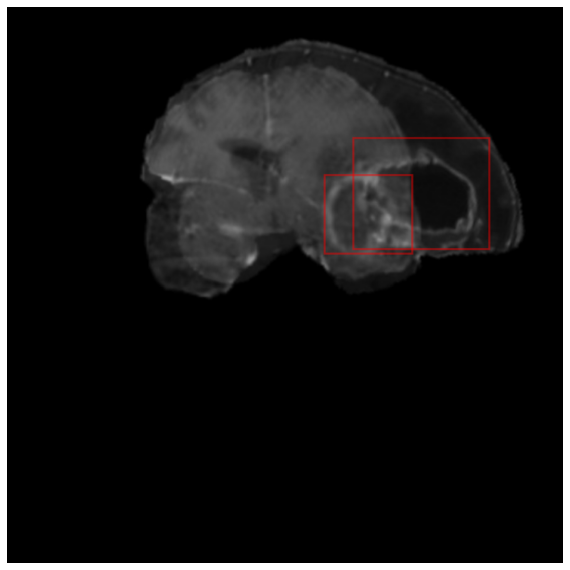

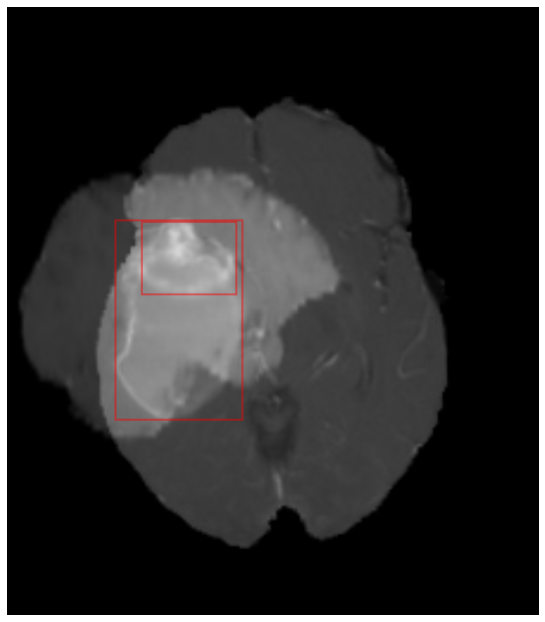

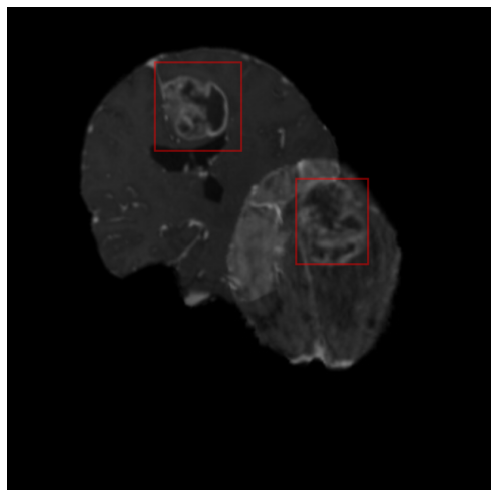

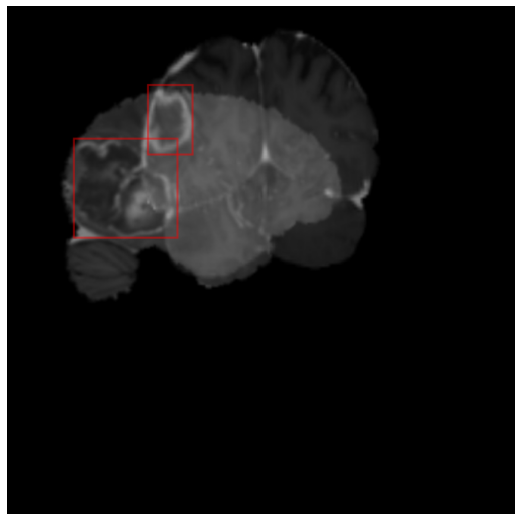

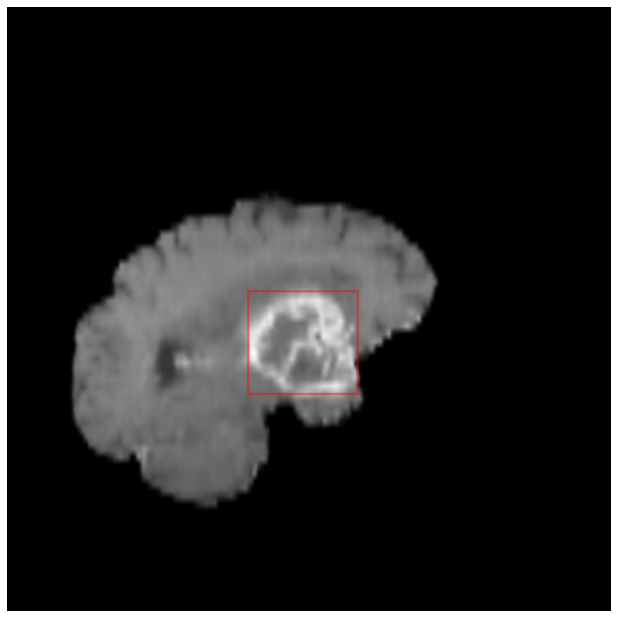

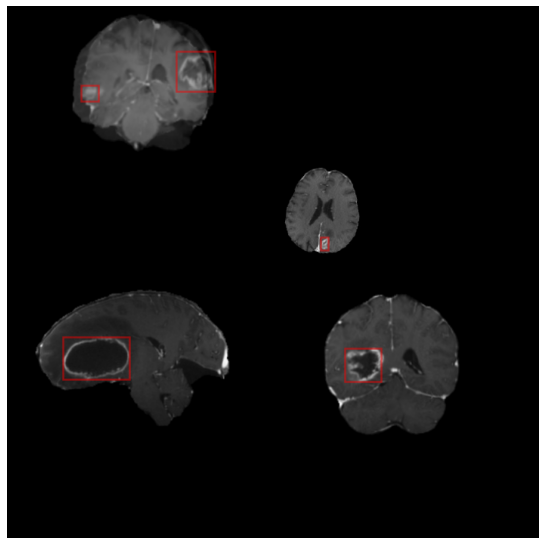

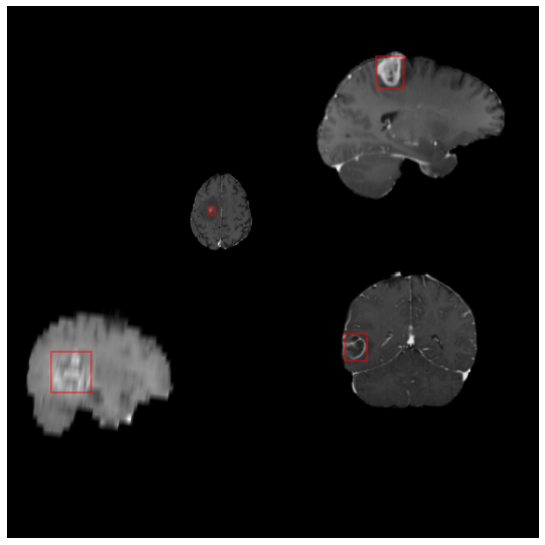

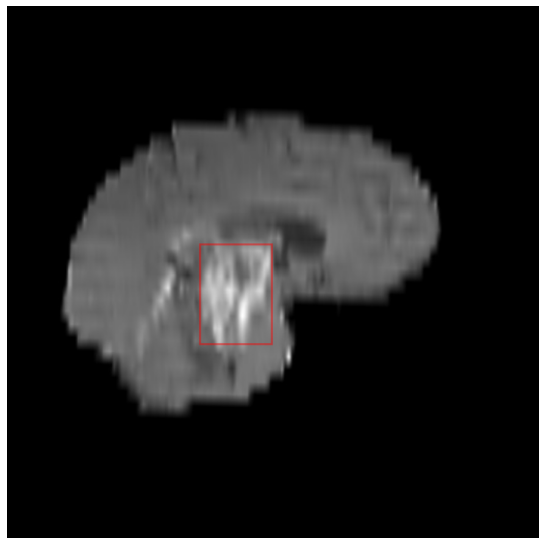

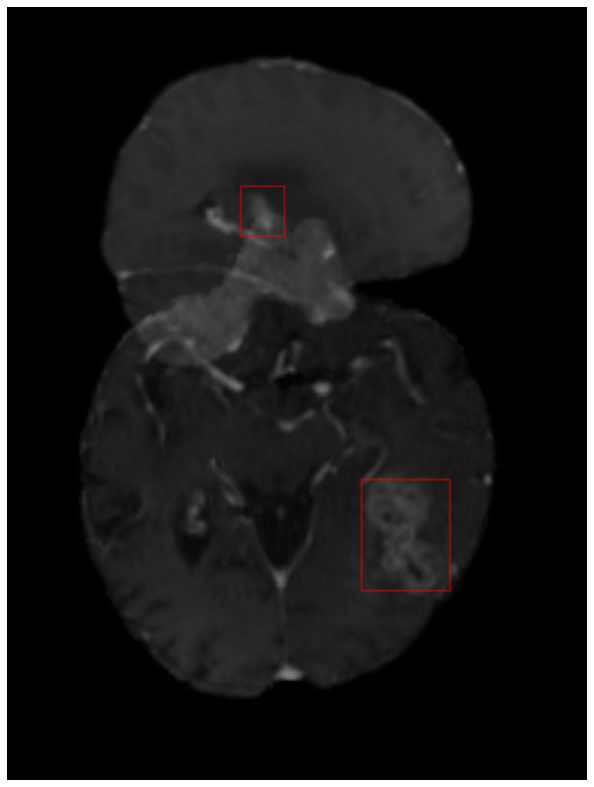

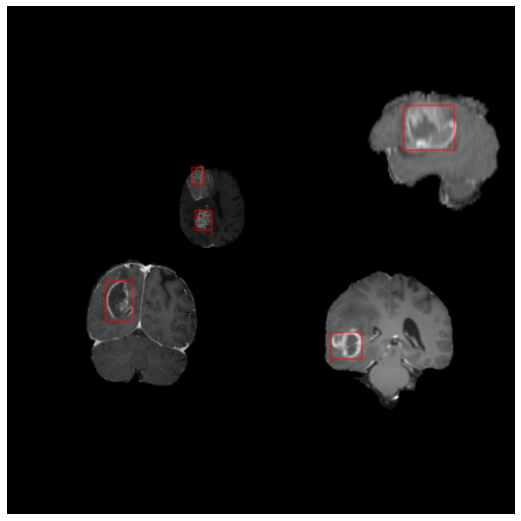

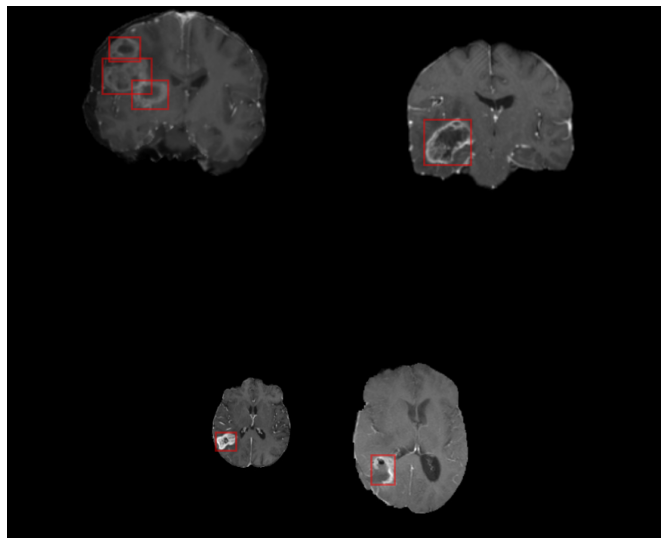

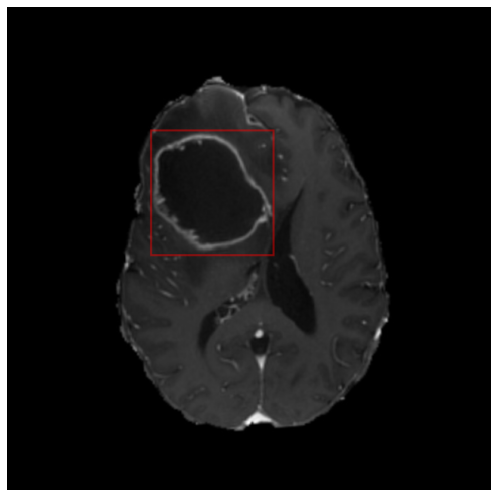

In [25]:

# display 2 training batch
tli = iter(trainer.data_loader)
for i in range(2):
  batch = next(tli)
  for sample in batch:
    visualize_sample(sample)

In [26]:
import gc
gc.collect()
     

51285

In [ ]:

trainer.train()

[03/20 13:07:30 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/20 13:07:47 d2.utils.events]:  eta: 0:40:25  iter: 19  total_loss: 2.404  loss_cls: 0.1656  loss_box_reg: 0.01531  loss_rpn_cls: 0.7429  loss_rpn_loc: 1.591    time: 0.2463  last_time: 0.2153  data_time: 0.0302  last_data_time: 0.0171   lr: 1.9981e-05  max_mem: 6105M
[03/20 13:07:52 d2.utils.events]:  eta: 0:40:05  iter: 39  total_loss: 1.556  loss_cls: 0.2233  loss_box_reg: 0.06787  loss_rpn_cls: 0.6443  loss_rpn_loc: 0.5809    time: 0.2422  last_time: 0.2407  data_time: 0.0188  last_data_time: 0.0173   lr: 3.9961e-05  max_mem: 6105M
[03/20 13:07:57 d2.utils.events]:  eta: 0:38:58  iter: 59  total_loss: 1.217  loss_cls: 0.15  loss_box_reg: 0.06605  loss_rpn_cls: 0.6453  loss_rpn_loc: 0.365    time: 0.2384  last_time: 0.2211  data_time: 0.0189  last_data_time: 0.0191   lr: 5.9941e-05  max_mem: 6105M
[03/20 13:08:01 d2.utils.events]:  eta: 0:39:03  iter: 79  total_loss: 1.136  loss_cls: 0.07852  loss_box_reg: 0.02708  loss_rpn_cls: 0.631  loss_rpn_loc: 0.3829    time: 0.2384  last_t

In [ ]:

import os
from glob import glob
files = glob(os.path.join(cfg.OUTPUT_DIR, "*.pth"))
for f in files:
  if f != os.path.join(cfg.OUTPUT_DIR, "model_best.pth"):
    os.remove(f)

In [ ]:

# workaround if the next cell brings locale error
import locale
locale.getpreferredencoding = lambda: "UTF-8"
     

In [ ]:

# zip
!zip -r {cfg.OUTPUT_DIR}.zip {cfg.OUTPUT_DIR}
from google.colab import files
files.download(cfg.OUTPUT_DIR+".zip")